# Análise de modelos: Doença cardiaca
<br>

- João Pedro Rocha
- Mateus Barbosa

<br>
Neste notebook, simularemos a busca de um modelo de ML para servir como um diagnóstico preliminar sobre caso um indivíduo está com uma doença cardiaca ou não. 

In [1]:
# Standard library
import sys
from time import perf_counter
from pathlib import Path
from functools import partial


# 3rth party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
from sklearn.utils import resample

## Improvising with the import path to use my tools
if "./edas" not in sys.path:
    sys.path.append("./edas")

# Local
from tools.standard_pipeline import load_and_process, init_pipeline, parse_categorical

plt.style.use("seaborn")

np.random.seed(123)

# Carregando e preparando os dados

In [2]:
BASE_DIR = Path("../datasets/heart_attack/")
RAW_FILE = BASE_DIR / Path("raw/heart_attack_data_set.csv")

pipeline = [
    init_pipeline, 
    partial(parse_categorical, to_categorical_percent=10),
]

ds = load_and_process(RAW_FILE, pipeline=pipeline)

ds.columns

Loaded from pickle, took: 0.01 s


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

A base de dados possui 5 colunas quantitativas:
- age
- trestbps
- chol 
- thalach
- oldpeak

E 9 colunas categóricas: 
- sex (binária)
- cp (categórica, ordinal)
- fbs (categórica, ordinal)
- restecg(categórica, ordinal)
- exang (categórica, ordinal)
- slope (categórica, ordinal**?**)
- ca (categórica, ordinal)
- thal (categórica, ordinal)
- target (binária)
    
Destas 9, duas são respostas: 
- thal
- target

Portanto temos 12 *features* para treinamento (7 categoricas e 5 quantitativas).

In [3]:
ds.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
21,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1
31,65,1,0,120,177,0,1,140,0,0.4,2,0,3,1
227,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0
58,34,1,3,118,182,0,0,174,0,0.0,2,0,2,1
169,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
29,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
168,63,1,0,130,254,0,0,147,0,1.4,1,1,3,0
84,42,0,0,102,265,0,0,122,0,0.6,1,0,2,1
173,58,1,2,132,224,0,0,173,0,3.2,2,2,3,0
266,55,0,0,180,327,0,2,117,1,3.4,1,0,2,0


Esta base está em um excelente estado para realizar a análise. A única coluna que aparentemente precisará de um encoder é a coluna "slope" (do tipo *One Hot*). Esta base poderia ser usada para dois tipos de predição: ou prever a categoria em "thal" que é um exame bastante confiável para a detecção de doenças cardíacas que pode indicar a severidade do problema, ou uma classificação binária entre doente ou não. 

<br>

Já que esta é uma base pequena, iremos realizar a tarefa mais simples de classificação binária, ou seja, doente ou não. Assim vamos separar os parâmetros do target descartando a coluna "thal" pois a mesma causaria um **data leak**, ou seja, esta é uma informação precisa vinda de um exame caro que em geral já daria um excelente diagnóstico por sí só, portanto treinando um algorítmo com esta informação ele naturalmente conseguiria diagnosticar os casos. Além disso, tendo um parâmetro tão preciso em mãos, seria desnecessário predizer a doença com um algorítmo.

In [4]:
data = ds.loc[:, [i for i in ds.columns if i not in ["thal", "target"]]]
target = ds.loc[:, "target"]

In [5]:
sum(target == 1), sum(target == 0)

(165, 138)

# Explorando modelos

<br>

Testaremos 6 modelos:

<br>

- Logistic Regression
- Random Forest
- Decision Three
- KNN
- SVM
- Gradient Boosted Tree

<br>
Vamos defini-los.

In [3]:
models = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "Decision Three": DecisionTreeClassifier,
    "KNN": KNeighborsClassifier,
    "SVM": SVC,
    "LGBoost": GradientBoostingClassifier,
}

Para este modelo usaremos duas transformações, uma em todas as colunas com o `StandardScaler` e uma na coluna "slope" com o `OneHotEncoder`. Vamos definir algumas funções para facilitar a experimentação com os modelos.

<br>

Inicialmente iremos aproveitar o comportamento padrão da função `train_test_split` para fazer um processo de bootstraping e ter uma estimativa da precisão de cada parâmetro e uma margem de confiança tirando 100 amostras diferentes dos dados.

In [6]:
def create_model(model):
    return model()

def experiment_v1(
    model_name, model, data, iterations=100, ohe=False, oversampling=False,
    downsampling=False
    ):
    ds = data.copy()
    
    assert not (oversampling and downsampling), "Can't downsample and oversample at the same time"
    
    # Setting up transformers
    scaler = StandardScaler()

    categorical_columns = ["slope"]
    categorical_transformer = OneHotEncoder()

    preprocessor = ColumnTransformer(
        transformers = [
            ("One Hot Encoding", categorical_transformer, categorical_columns)
        ]
    )
    
    pipe = [
        ("Scaler", scaler),
        ("Model", create_model(model))
    ]
    
    # Optionally use One Hot Encoding
    if ohe:
        pipe.insert(0, ("Column Transformations", preprocessor))
    
    model = Pipeline(pipe)
    
    # Starting up lists
    score = []
    r_score = []
    times = []
    
    score_train = []
    r_score_train = []
    
    for i in range(iterations):
        
        if oversampling:
            data_minority = ds.loc[ds.target == 0, :]
            data_majority = ds.loc[ds.target == 1, :]
            
            data_minority_over = resample(data_minority, replace=True, n_samples=data_majority.shape[0])
            ds = pd.concat([data_majority, data_minority_over], axis=0)
            
        if downsampling:
            data_minority = ds.loc[ds.target == 0, :]
            data_majority = ds.loc[ds.target == 1, :]
            
            data_majority_under = resample(data_majority, n_samples=data_minority.shape[0])
            ds = pd.concat([data_minority, data_majority_under], axis=0)
        
        # Divide test and train data again to shuffle data
        data = ds.loc[:, [i for i in ds.columns if i not in ["thal", "target"]]]
        target = ds.loc[:, "target"]
            
        train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3)
        
        tic = perf_counter()
        model.fit(train_x, train_y)  #  Training
        times.append(perf_counter() - tic)
        #  Testing
        score.append(model.score(test_x, test_y) )
        r_score.append(recall_score(model.predict(test_x), test_y))
        score_train.append(accuracy_score(model.predict(train_x), train_y))
        r_score_train.append(recall_score(model.predict(train_x), train_y))

        
    print(f"{model_name} -> Accuracy ({np.mean(score)*100:.3f} +- {np.std(score)*100:.3f})%. Recall ({np.mean(r_score)*100:.3f} +- {np.std(r_score)*100:.3f})%. Execution Time: ({np.mean(times):.3f} +- {np.std(score):.3f}) sec")
        
    return score, r_score, times, score_train, r_score_train


def plot_dists(score, r_score, times, score_train, r_score_train, nbin=15):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    
    ax1.hist(x=score, histtype="stepfilled", alpha=0.5, bins=nbin, label="Test")
    ax1.hist(x=score_train, histtype="stepfilled", alpha=0.5, bins=nbin, label="Train")
    ax2.hist(x=r_score, histtype="stepfilled", alpha=0.5, bins=nbin, label="Test")
    ax2.hist(x=r_score_train, histtype="stepfilled", alpha=0.5, bins=nbin, label="Train")
    ax3.hist(x=times, histtype="stepfilled", alpha=0.5, bins=nbin)

    
    ax1.set(xlabel="Accurary", title="Accuracy Distribution", xlim=[.5, 1.05])
    ax2.set(xlabel="Recall", title="Recal Distribution", xlim=[.5, 1.05])
    ax3.set(xlabel="Time / [sec]", title="Time Distribution")
    
    ax1.legend()
    ax2.legend()
    
    plt.show()


Vamos fazer agora os testes. Primeiro usando One Hot Encoding.

Logistic Regression -> Accuracy (69.231 +- 4.164)%. Recall (74.324 +- 6.158)%. Execution Time: (0.017 +- 0.042) sec


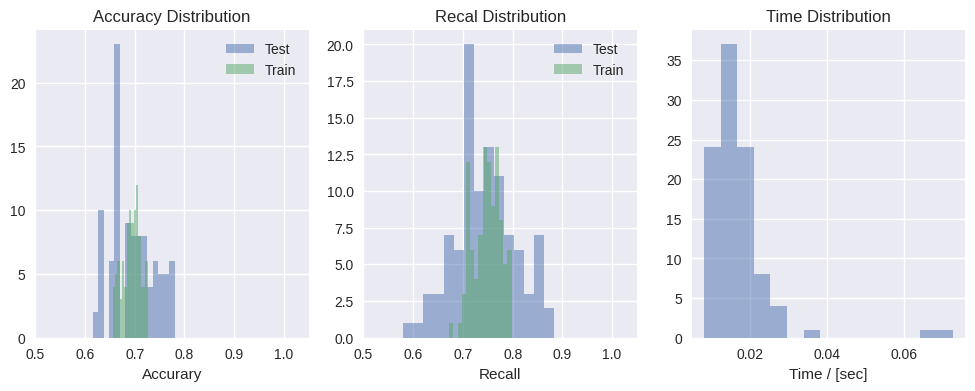

Random Forest -> Accuracy (69.099 +- 4.418)%. Recall (74.331 +- 6.214)%. Execution Time: (0.246 +- 0.044) sec


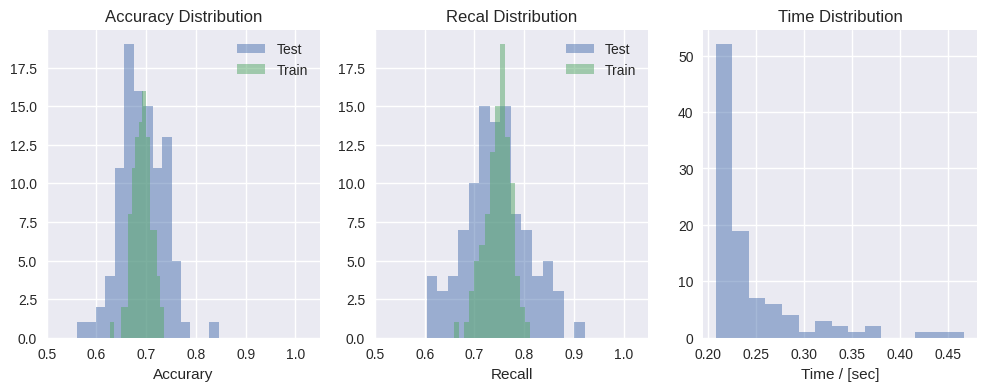

Decision Three -> Accuracy (68.648 +- 4.194)%. Recall (74.591 +- 6.806)%. Execution Time: (0.007 +- 0.042) sec


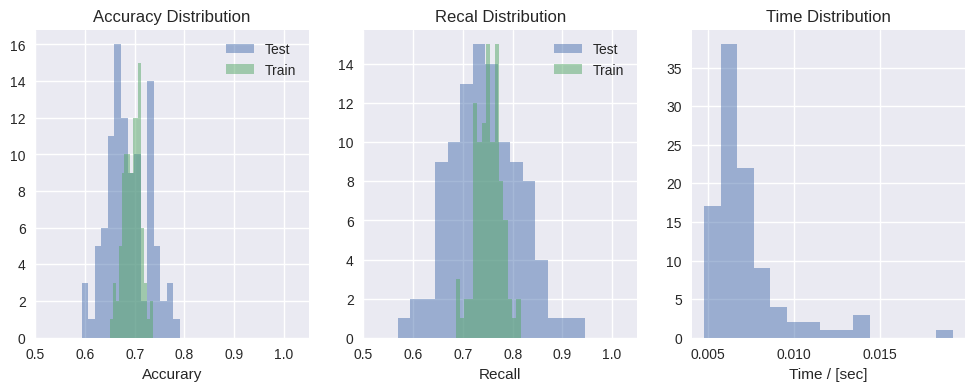

/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/skl

KNN -> Accuracy (62.626 +- 9.747)%. Recall (65.158 +- 16.667)%. Execution Time: (0.007 +- 0.097) sec


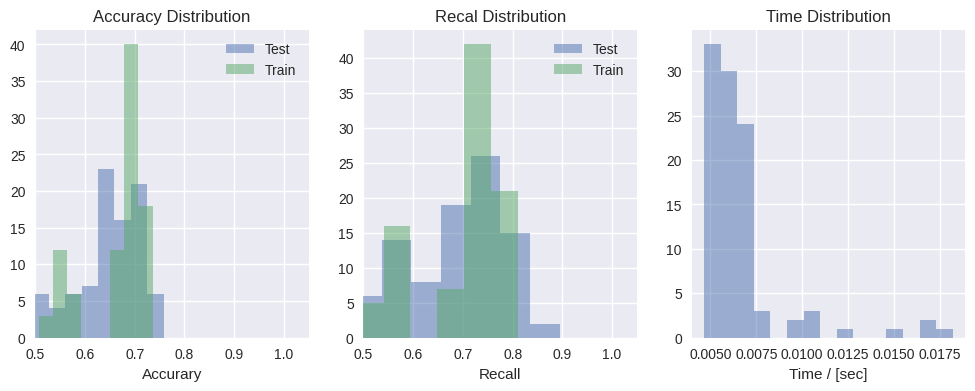

SVM -> Accuracy (68.813 +- 4.102)%. Recall (74.652 +- 5.401)%. Execution Time: (0.010 +- 0.041) sec


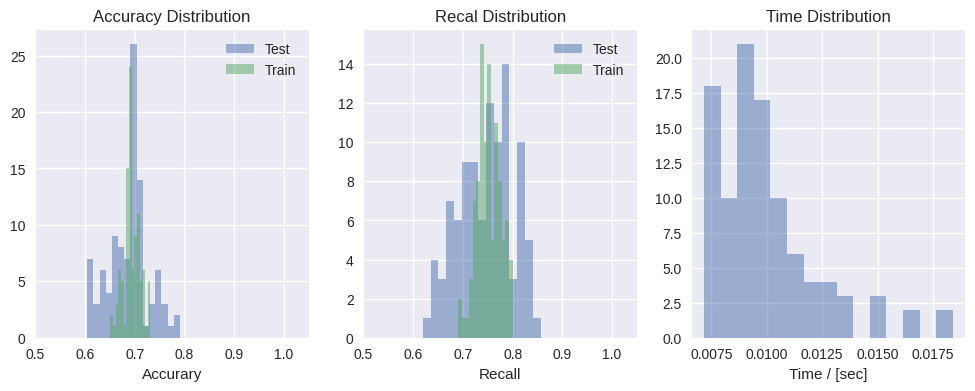

LGBoost -> Accuracy (68.275 +- 3.875)%. Recall (74.008 +- 5.699)%. Execution Time: (0.091 +- 0.039) sec


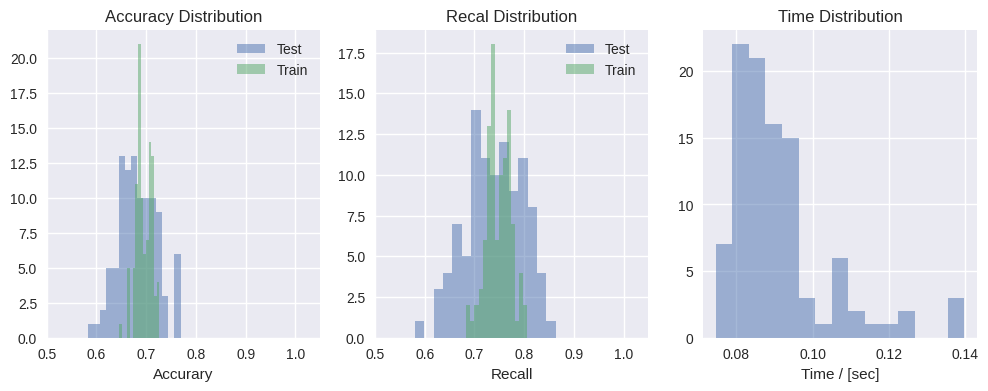

In [7]:
for model_name, model in models.items():
    plot_dists(*experiment_v1(model_name, model, ds, ohe=True))

Acurácia ficou por volta de 70%. Vamos testar sem o *One Hot Encoding*.

Logistic Regression -> Accuracy (81.198 +- 3.415)%. Recall (81.168 +- 5.025)%. Execution Time: (0.028 +- 0.034) sec


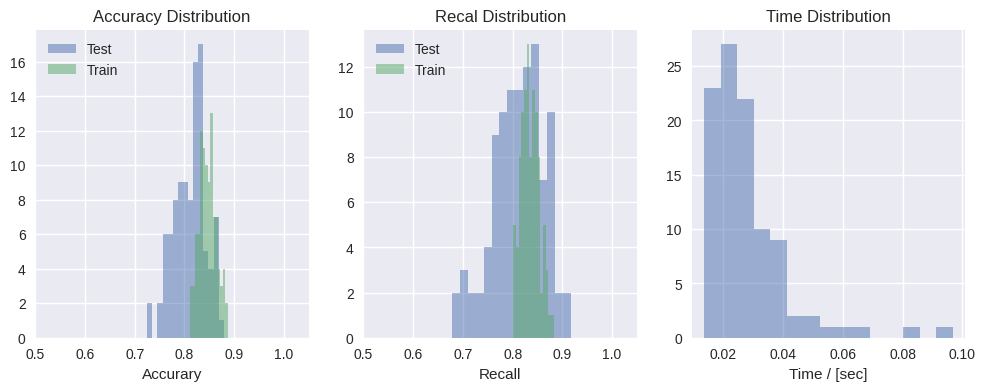

Random Forest -> Accuracy (81.571 +- 3.641)%. Recall (81.459 +- 4.960)%. Execution Time: (0.280 +- 0.036) sec


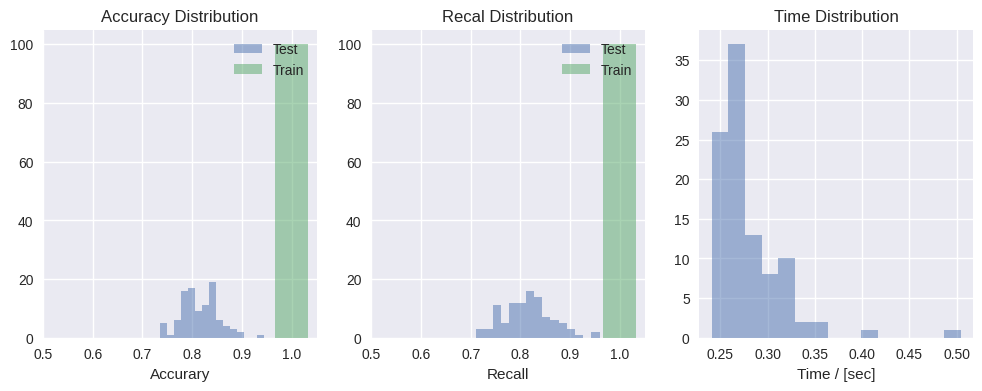

Decision Three -> Accuracy (74.099 +- 4.532)%. Recall (75.788 +- 5.654)%. Execution Time: (0.011 +- 0.045) sec


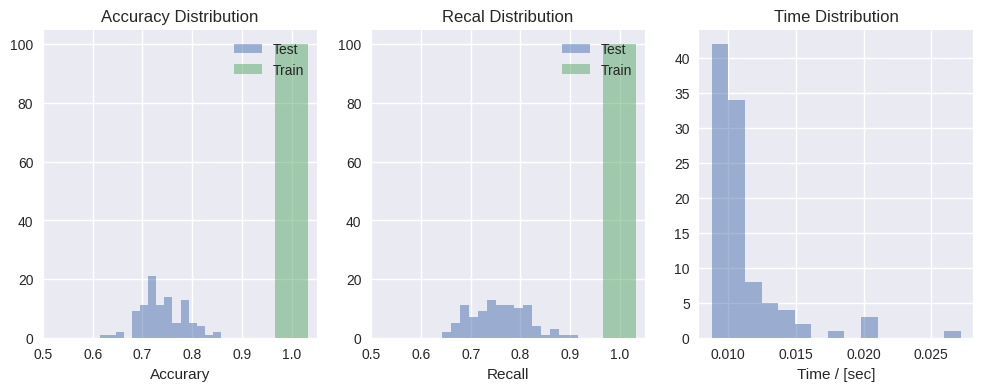

KNN -> Accuracy (79.297 +- 3.822)%. Recall (79.196 +- 5.075)%. Execution Time: (0.010 +- 0.038) sec


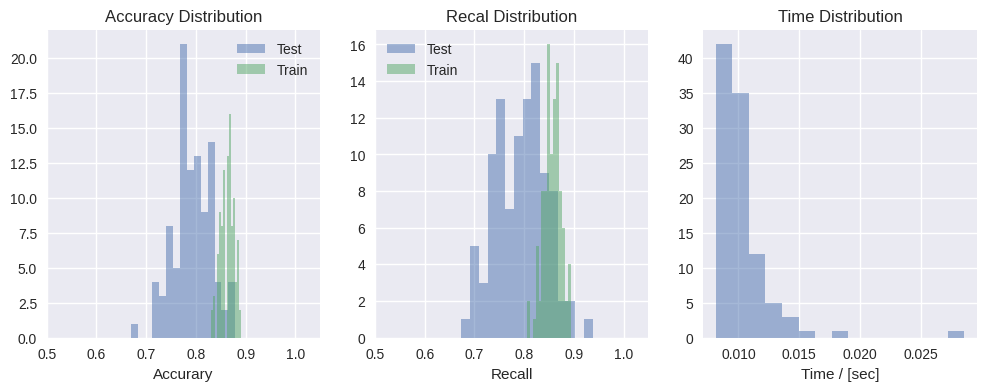

SVM -> Accuracy (81.286 +- 3.702)%. Recall (79.879 +- 5.354)%. Execution Time: (0.016 +- 0.037) sec


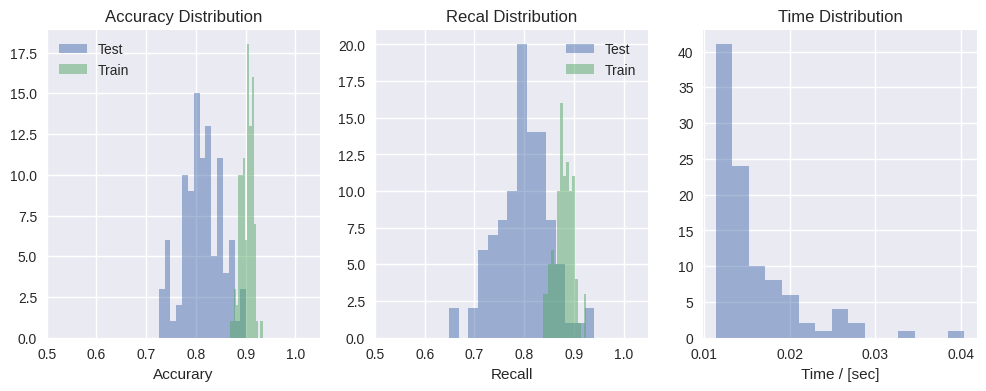

LGBoost -> Accuracy (80.099 +- 3.598)%. Recall (80.425 +- 4.795)%. Execution Time: (0.170 +- 0.036) sec


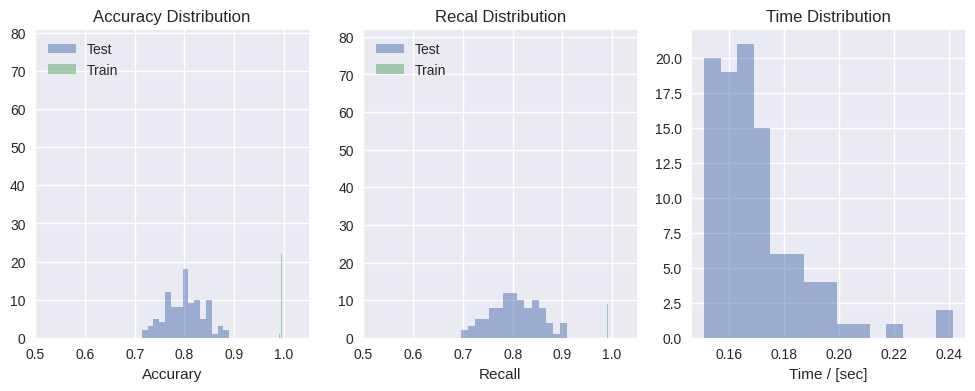

In [8]:
for model_name, model in models.items():
    plot_dists(*experiment_v1(model_name, model, ds, ohe=False))

Acurácia subiu para por volta de 80%. O *One Hot Encoding* não ajudou com o parâmetro que estavamos testando. Aparentemente há uma relação ordinal na coluna "slope".

<br>

A Regressão Logística parece o melhor modelo. Apesar do score da Floresta Aleatória estar maior, parece que a mesma está com bastante *overfitting*, pois a distribuição do score com os dados do próprio treinamento está bem definida em perto de 1. Isto é ainda menos desejável, dado que o treinamento está sendo feito numa base de dados bem pequena.

<br>

A segunda melhor alternativa seria a SVM. O *score* está relativamente alto e as distribuições do score vindo do treinamento e da validação estão mais sobrepostas. No entanto no caso da Regressão Logística estão ainda mais sobrepostas. E portanto a regressão logística parece ter tido o melhor resultado com o menor *overfitting*.

<br>

Vamos ver o que ocorre se balancearmos o conjunto de dados.

Logistic Regression -> Accuracy (90.384 +- 4.856)%. Recall (93.856 +- 7.584)%. Execution Time: (0.041 +- 0.049) sec


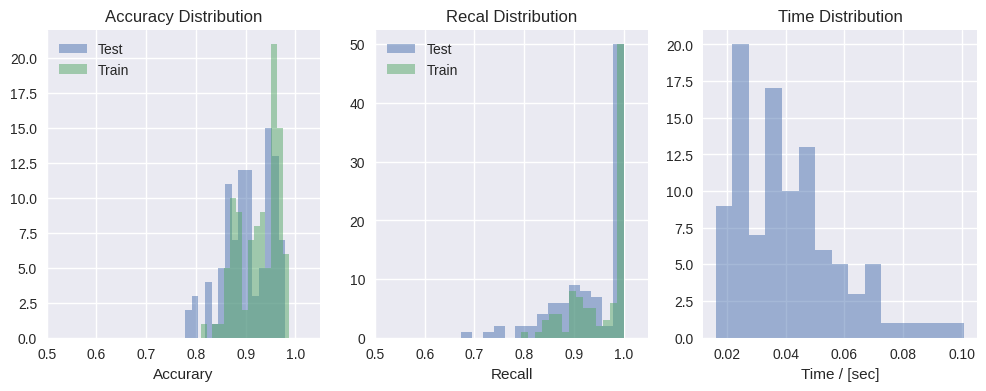

Random Forest -> Accuracy (98.919 +- 2.260)%. Recall (99.364 +- 2.172)%. Execution Time: (0.302 +- 0.023) sec


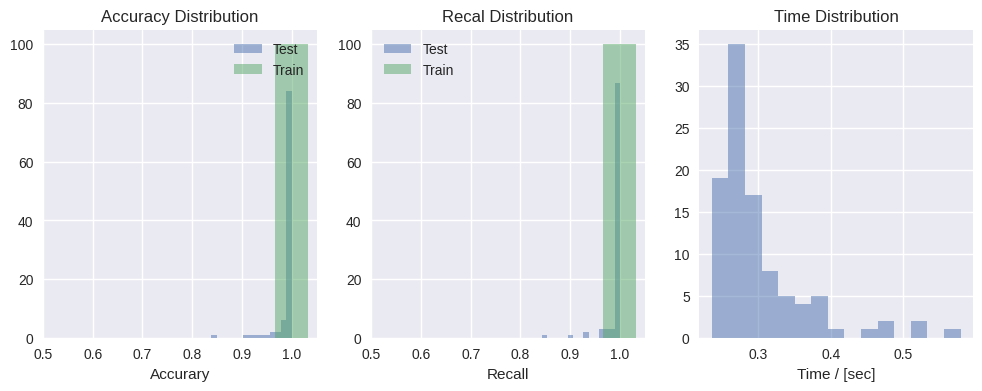

Decision Three -> Accuracy (96.980 +- 2.727)%. Recall (99.430 +- 1.626)%. Execution Time: (0.012 +- 0.027) sec


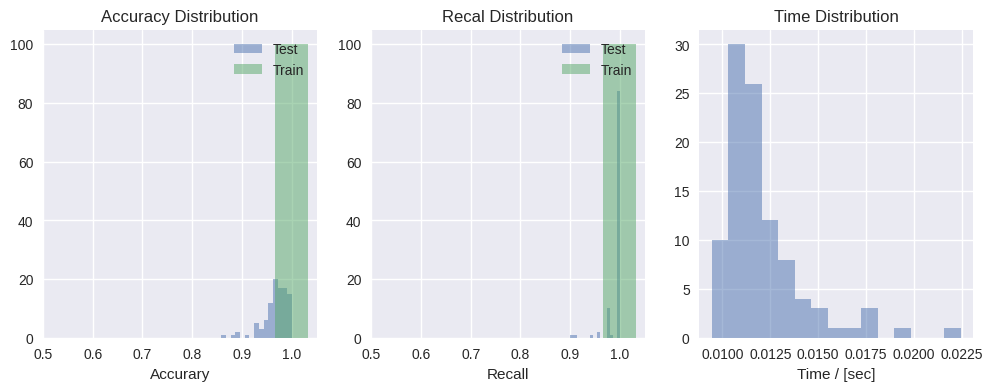

KNN -> Accuracy (93.475 +- 3.818)%. Recall (98.297 +- 4.549)%. Execution Time: (0.012 +- 0.038) sec


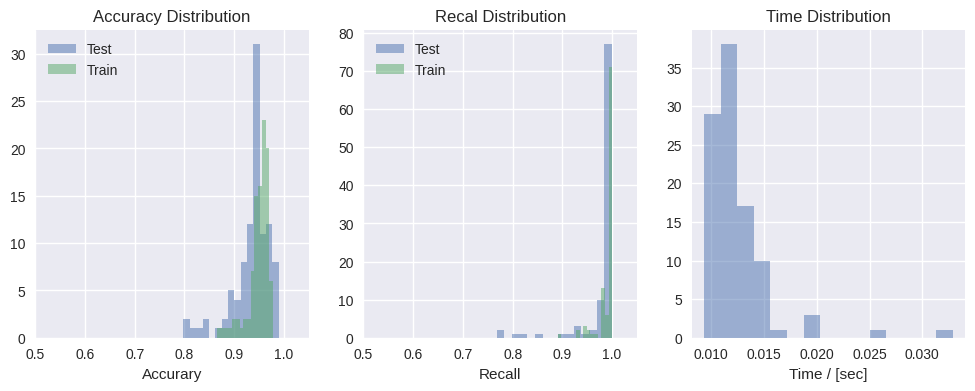

SVM -> Accuracy (96.535 +- 4.182)%. Recall (97.074 +- 5.160)%. Execution Time: (0.014 +- 0.042) sec


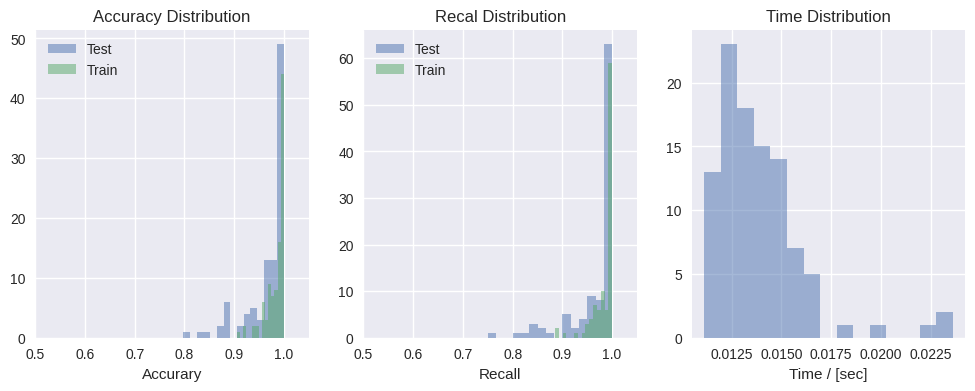

LGBoost -> Accuracy (98.404 +- 2.404)%. Recall (99.476 +- 1.803)%. Execution Time: (0.161 +- 0.024) sec


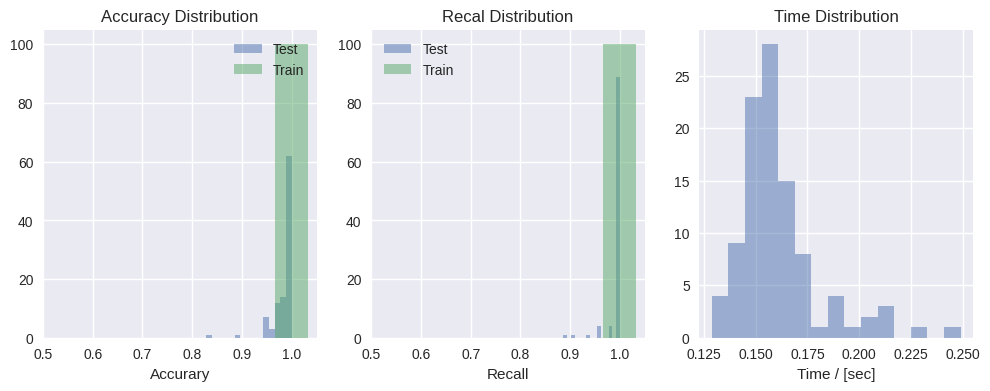

In [9]:
for model_name, model in models.items():
    plot_dists(*experiment_v1(model_name, model, ds, ohe=False, oversampling=True))

O resultado com a base balanceada foi surpreendentemente mais preciso apesar do desbalanceamento ser pequeno! Vamos ver se não é algum viés introduzido pela repetição de informação. Invés de usar oversampling, vamos usar downsampling.

Logistic Regression -> Accuracy (96.169 +- 3.563)%. Recall (93.809 +- 5.142)%. Execution Time: (0.020 +- 0.036) sec


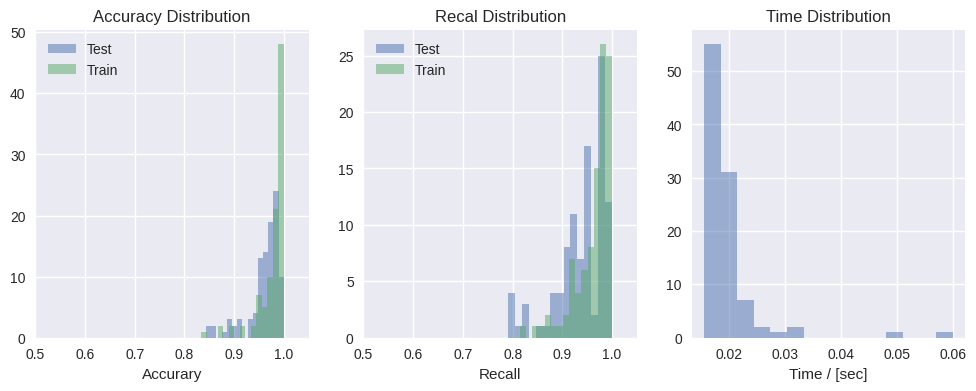

Random Forest -> Accuracy (97.530 +- 3.785)%. Recall (96.312 +- 4.749)%. Execution Time: (0.211 +- 0.038) sec


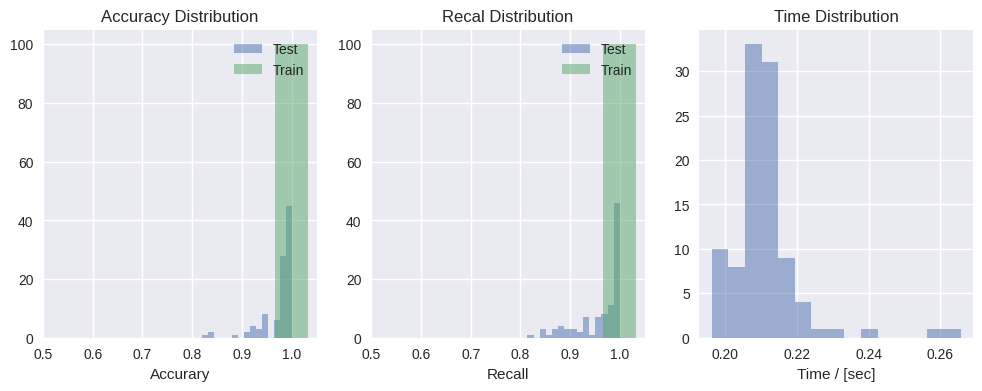

Decision Three -> Accuracy (95.627 +- 4.333)%. Recall (92.780 +- 5.834)%. Execution Time: (0.010 +- 0.043) sec


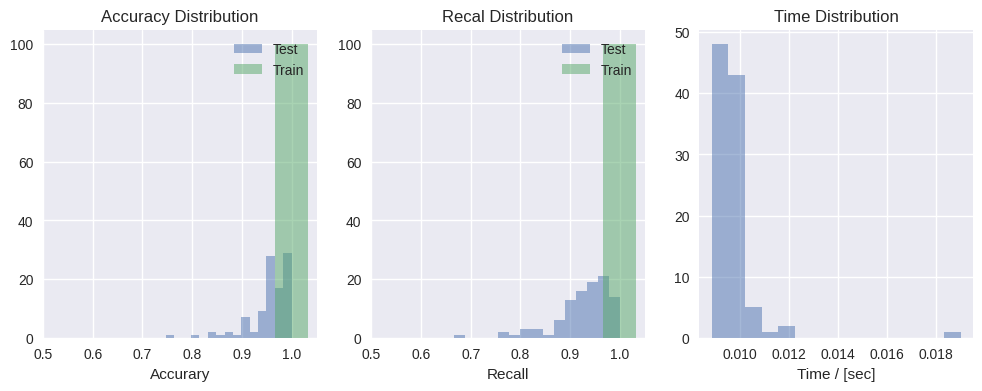

KNN -> Accuracy (94.169 +- 5.497)%. Recall (91.709 +- 6.877)%. Execution Time: (0.009 +- 0.055) sec


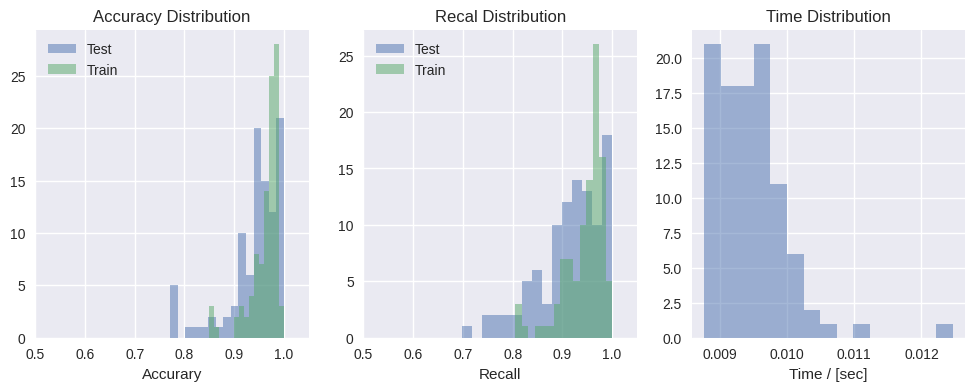

SVM -> Accuracy (96.434 +- 4.194)%. Recall (94.888 +- 6.199)%. Execution Time: (0.011 +- 0.042) sec


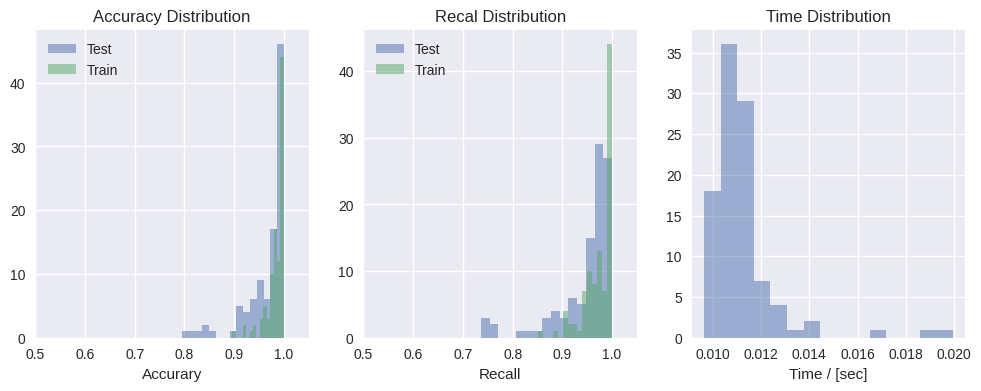

LGBoost -> Accuracy (97.241 +- 3.035)%. Recall (95.992 +- 3.677)%. Execution Time: (0.130 +- 0.030) sec


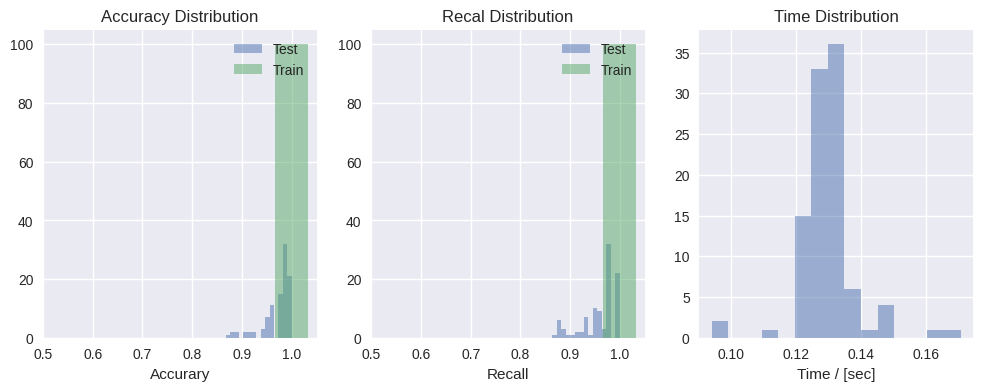

In [13]:
for model_name, model in models.items():
    plot_dists(*experiment_v1(model_name, model, ds, ohe=False, downsampling=True))

Com downsampling ainda tivemos uma melhoria significativa ... Portanto, aparentemente não é um viés. Neste caso vamos continuar usando o oversampling para não jogar fora a informação do conjunto de dados.

<br>

Neste cenário o melhor modelo parece ser o da SVM, pois o mesmo tem uma alta precisão porém mantendo um pouco de variância

<br>

**OBS: Esta célula toma bastante tempo para rodar**

Logistic Regression -> Accuracy (98.275 +- 2.259)%. Recall (99.678 +- 1.920)%. Execution Time: (0.019 +- 0.023) sec


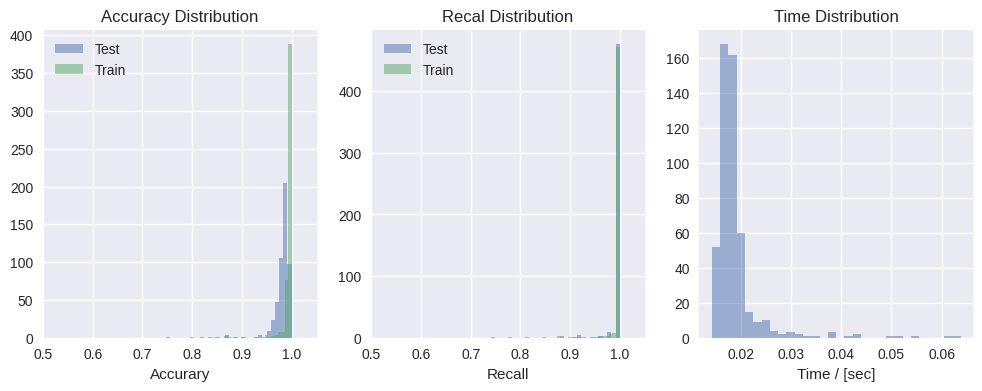

Random Forest -> Accuracy (99.749 +- 1.160)%. Recall (99.845 +- 0.984)%. Execution Time: (0.211 +- 0.012) sec


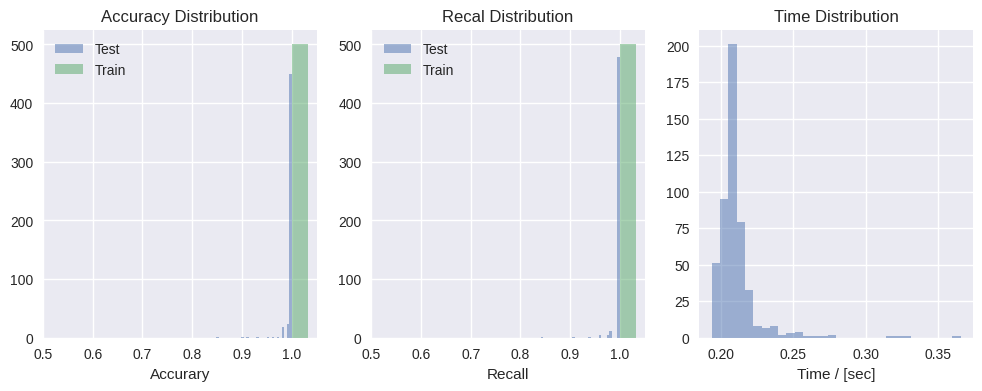

Decision Three -> Accuracy (98.810 +- 1.952)%. Recall (99.814 +- 1.133)%. Execution Time: (0.010 +- 0.020) sec


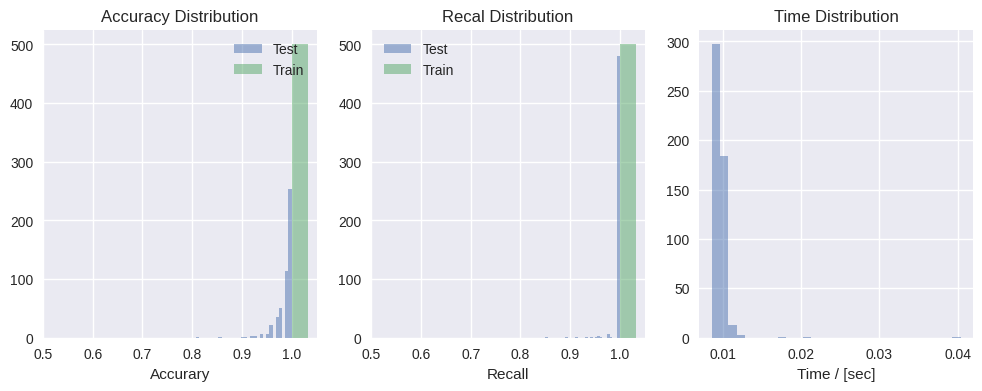

KNN -> Accuracy (98.226 +- 2.180)%. Recall (99.676 +- 1.679)%. Execution Time: (0.009 +- 0.022) sec


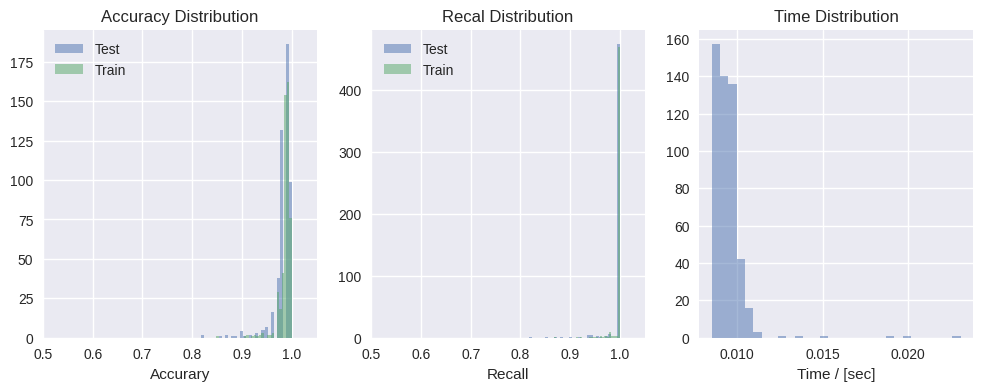

SVM -> Accuracy (99.560 +- 1.761)%. Recall (99.552 +- 2.308)%. Execution Time: (0.011 +- 0.018) sec


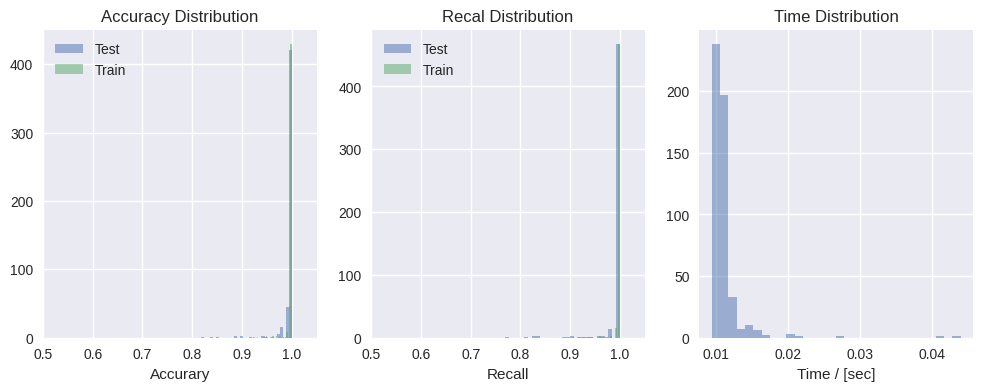

LGBoost -> Accuracy (99.012 +- 1.565)%. Recall (99.834 +- 1.120)%. Execution Time: (0.100 +- 0.016) sec


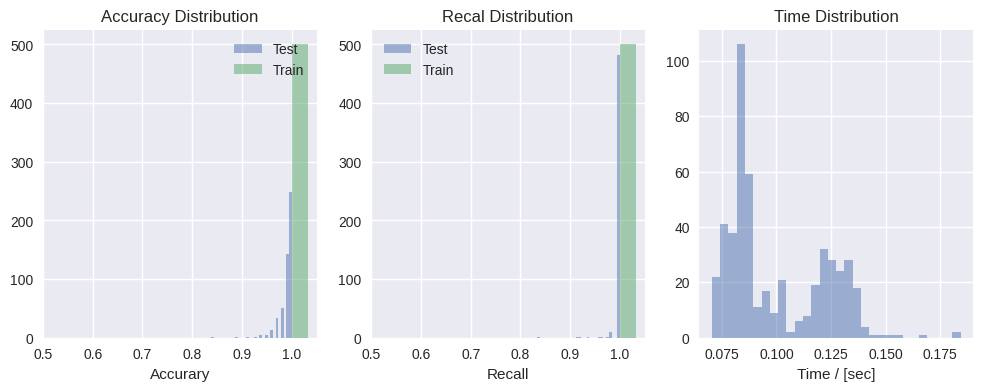

In [14]:
for model_name, model in models.items():
    plot_dists(
        *experiment_v1(
            model_name,
            model, 
            ds, 
            iterations=500,
            ohe=False, 
            oversampling=True),
        nbin=30)

Com um número de iterações maior, a **SVM** ainda parece ser a melhor escolha dado o compromisso entre precisão e variância. O segundo melhor modelo seria o **KNN**, pois o mesmo também tem uma variância razoável.

<br>

Vamos compará-los usando o K-Fold. Que é uma técnica mais padrão para a validação.

# Validação cruzada: K-Fold

<br>

Vamos definir um experimento encorporando o que aprendemos anteriormente, só q dessa vez usando o K-Fold.

In [5]:
def experiment_v2(model_name, model, dataset, k=5, oversampling=False):
    
    ds = dataset.copy()
    kf = KFold(n_splits=k, shuffle=True)
    
    # Setting up transformers
    scaler = StandardScaler()
    
    pipe = [
        ("Scaler", scaler),
        ("Model", create_model(model))
    ]
    
    model = Pipeline(pipe)
    
    # Starting up lists
    score = []
    r_score = []
    times = []
    
    score_train = []
    r_score_train = []

        
    if oversampling:
        data_minority = ds.loc[ds.target == 0, :]
        data_majority = ds.loc[ds.target == 1, :]

        data_minority_over = resample(data_minority, replace=True, n_samples=data_majority.shape[0])
        ds = pd.concat([data_majority, data_minority_over], axis=0)

    # Divide test and train data again to shuffle data
    data = ds.loc[:, [i for i in ds.columns if i not in ["thal", "target"]]]
    target = ds.loc[:, "target"]

    for train_index, test_index in kf.split(ds):
        
        train_x = data.iloc[train_index]
        train_y = target.iloc[train_index]
        
        test_x = data.iloc[test_index]
        test_y = target.iloc[test_index]

        tic = perf_counter()
        model.fit(train_x, train_y)  #  Training
        times.append(perf_counter() - tic)
        #  Testing
        score.append(model.score(test_x, test_y) )
        r_score.append(recall_score(model.predict(test_x), test_y))
        score_train.append(accuracy_score(model.predict(train_x), train_y))
        r_score_train.append(recall_score(model.predict(train_x), train_y))

        
    print(f"{model_name} -> Accuracy ({np.mean(score)*100:.3f} +- {np.std(score)*100:.3f})%. Recall ({np.mean(r_score)*100:.3f} +- {np.std(r_score)*100:.3f})%. Execution Time: ({np.mean(times):.3f} +- {np.std(score):.3f}) sec")
        
    return score, r_score, times, score_train, r_score_train


def plot_ks(score, r_score, times, score_train, r_score_train):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    
    ax1.plot(range(len(score)), score, marker="o", label="Test")
    ax1.plot(range(len(score)), score_train, marker="o", label="Train")
    ax2.plot(range(len(score)), r_score, marker="o", label="Test")
    ax2.plot(range(len(score)), r_score_train, marker="o", label="Train")

    
    ax1.set(xlabel="Accurary", title="Accuracy scores", ylim=[.6, 1.05])
    ax2.set(xlabel="Recall", title="Recal scores", ylim=[.6, 1.05])
    
    ax1.legend()
    ax2.legend()
    
    plt.show()


Logistic Regression -> Accuracy (82.431 +- 2.739)%. Recall (81.847 +- 4.401)%. Execution Time: (0.018 +- 0.027) sec


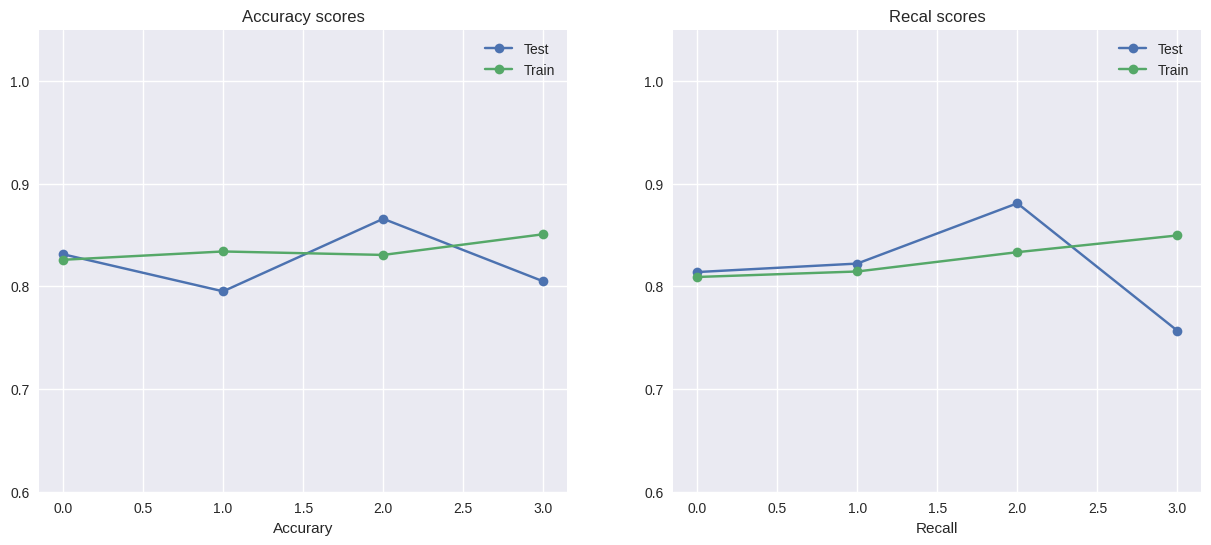

Random Forest -> Accuracy (92.745 +- 4.242)%. Recall (93.416 +- 5.968)%. Execution Time: (0.220 +- 0.042) sec


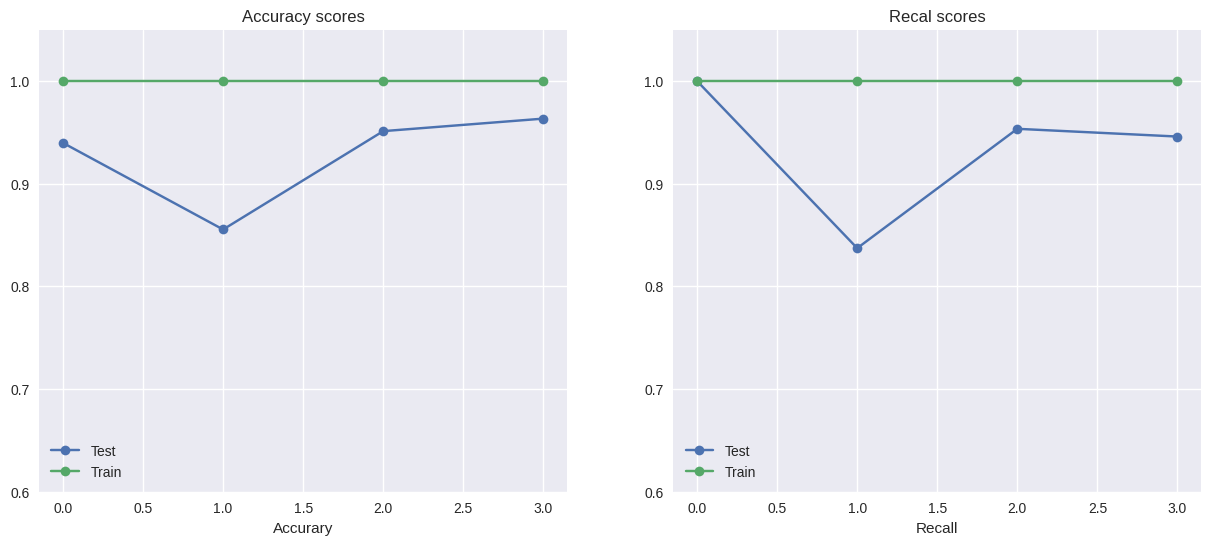

Decision Three -> Accuracy (80.892 +- 3.234)%. Recall (85.773 +- 8.396)%. Execution Time: (0.010 +- 0.032) sec


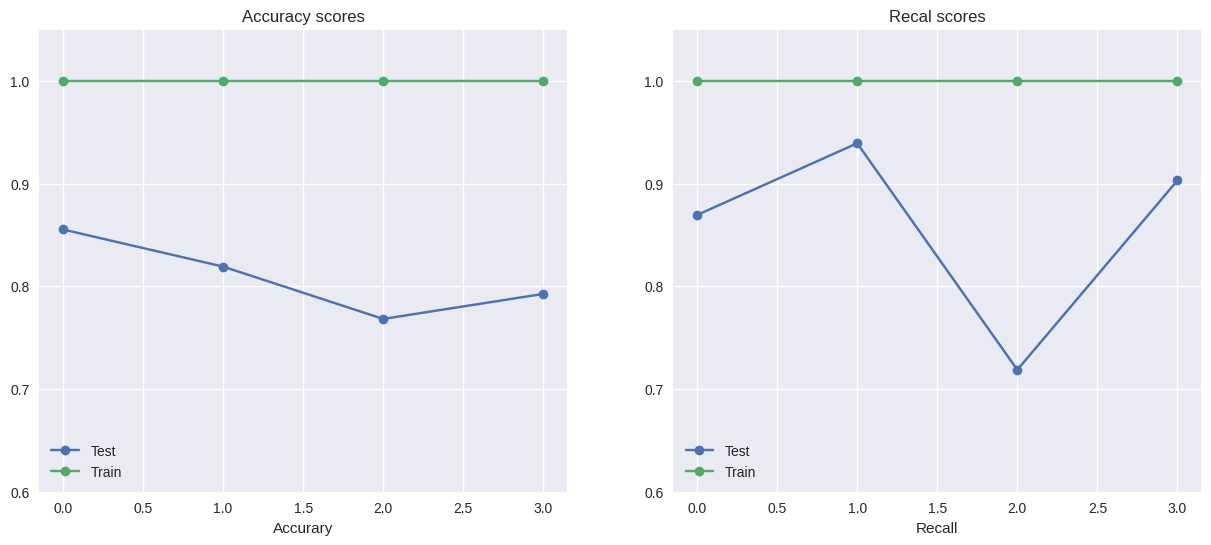

KNN -> Accuracy (81.204 +- 4.594)%. Recall (81.616 +- 4.623)%. Execution Time: (0.009 +- 0.046) sec


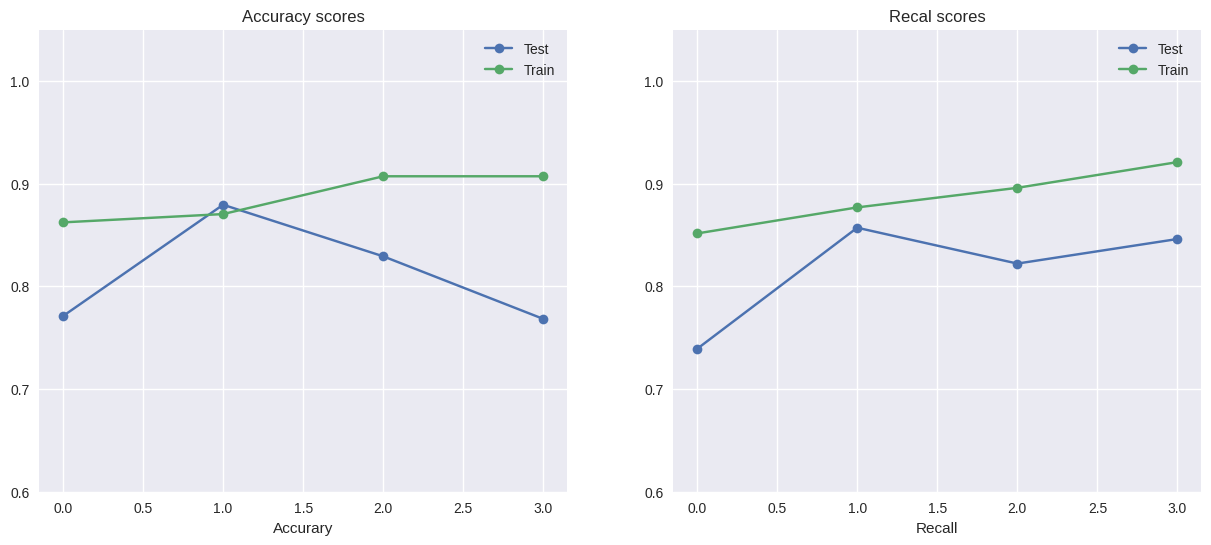

SVM -> Accuracy (84.550 +- 0.920)%. Recall (82.156 +- 3.815)%. Execution Time: (0.012 +- 0.009) sec


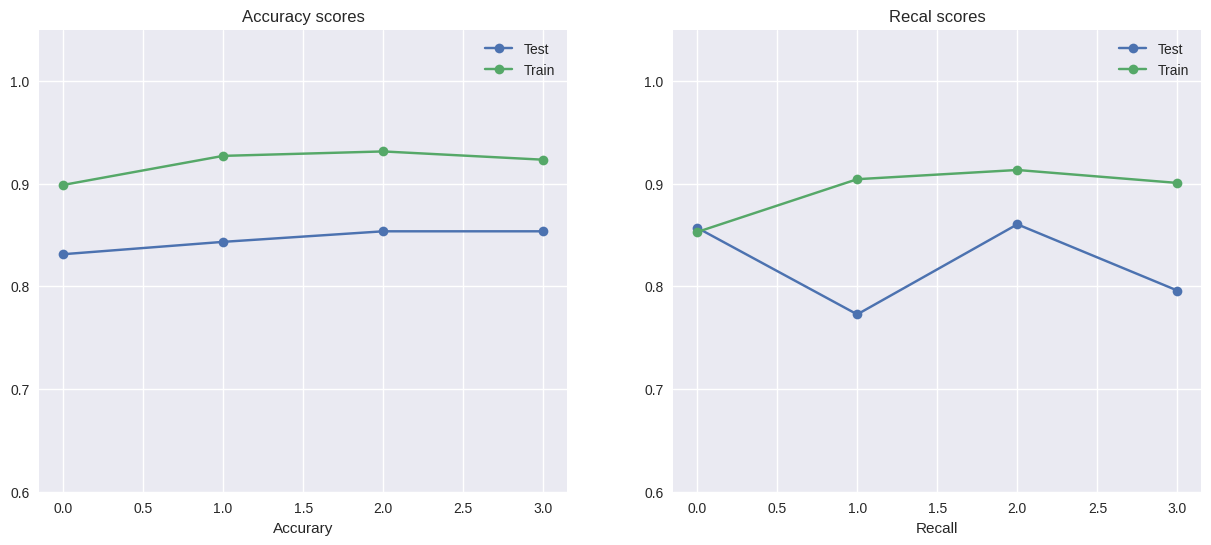

LGBoost -> Accuracy (86.978 +- 3.918)%. Recall (90.524 +- 1.719)%. Execution Time: (0.154 +- 0.039) sec


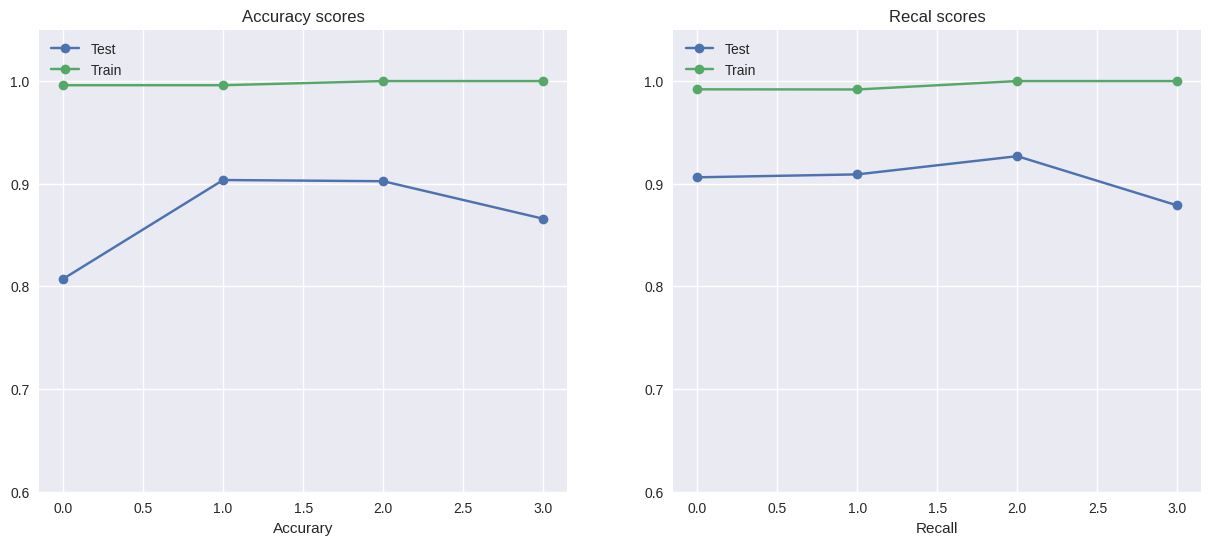

In [16]:
for model_name, model in models.items():
    plot_ks(*experiment_v2(model_name, model, ds, k=4, oversampling=True))

Usando K Fold temos resultados diferentes. Neste caso, a regressão logística mostra uma variância mais "saudável" e em segundo lugar vem a SVM. Vamos verificar a matriz de confusão para ambos.

# Verificando modelos escolhidos

In [17]:
def prepare_model(model, dataset, oversampling=True):
    ds = dataset.copy()
    
    # Setting up transformers
    scaler = StandardScaler()

    pipe = [
        ("Scaler", scaler),
        ("Model", model)
    ]
    
    model = Pipeline(pipe)
    
    if oversampling:
        data_minority = ds.loc[ds.target == 0, :]
        data_majority = ds.loc[ds.target == 1, :]

        data_minority_over = resample(data_minority, replace=True, n_samples=data_majority.shape[0])
        ds = pd.concat([data_majority, data_minority_over], axis=0)


    # Divide test and train data again to shuffle data
    data = ds.loc[:, [i for i in ds.columns if i not in ["thal", "target"]]]
    target = ds.loc[:, "target"]
    
    return model, data, target


def train_model(model, dataset, oversampling=False, plot_cm=True):
    
    ds = dataset.copy()
    
    # Setting up transformers
    scaler = StandardScaler()

    pipe = [
        ("Scaler", scaler),
        ("Model", model)
    ]
    
    model = Pipeline(pipe)
    
    if oversampling:
        data_minority = ds.loc[ds.target == 0, :]
        data_majority = ds.loc[ds.target == 1, :]

        data_minority_over = resample(data_minority, replace=True, n_samples=data_majority.shape[0])
        ds = pd.concat([data_majority, data_minority_over], axis=0)


    # Divide test and train data again to shuffle data
    data = ds.loc[:, [i for i in ds.columns if i not in ["thal", "target"]]]
    target = ds.loc[:, "target"]

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3)
    model.fit(train_x, train_y)
    if plot_cm:
        ConfusionMatrixDisplay(confusion_matrix(test_y, model.predict(test_x))).plot()
        plt.gca().set_title(f"Accuracy: {model.score(test_x, test_y):.2f}")
    
    return model

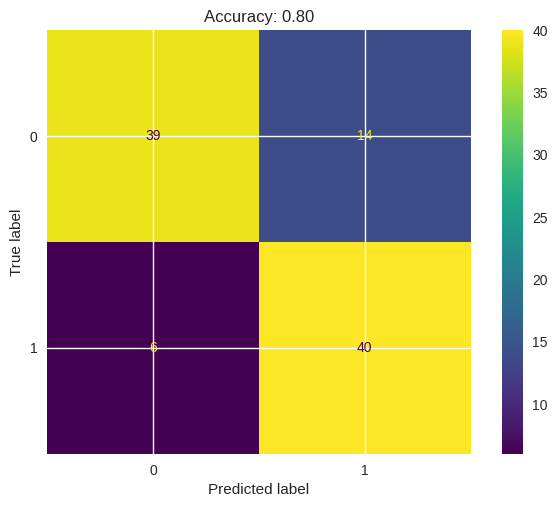

In [18]:
model = train_model(models["SVM"], ds, oversampling=True)

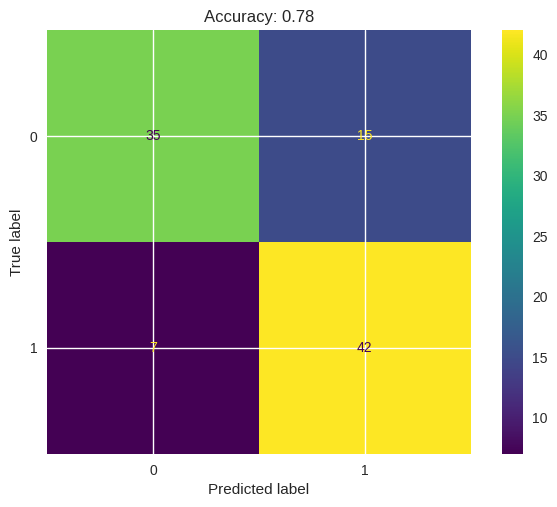

In [19]:
model = train_model(models["Logistic Regression"], ds, oversampling=True)

A SVM parece mais interessante, mas uma característica desejável para essa aplicação na área de saúde, seria otimizar o *recall* para minimizar falsos negativos mesmo que os falsos positivos aumentem ... Vamos tunar os hiperparâmetros desses modelos para otimizar esta métrica.

<br>

Uma [referência interessante](https://arxiv.org/pdf/2204.02526.pdf) sobre isso.



# Tunando hiperparâmetros

Vamos otimizar o *recall*! Lembrando que recall é:

$$Recall = \frac{TP}{TP + FN}$$

Ou seja, vamos adicionar uma "punição" por falsos negativos.

/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
280 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/

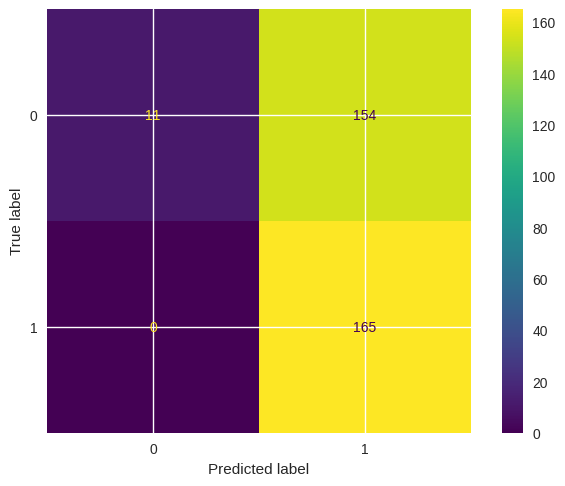

In [22]:
param_grid = {
    'Model__C': np.logspace(-3,3,7),
    'Model__gamma': ["scale", "auto"],
    'Model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'Model__degree': [2, 3, 4, 5]
}

model, data, target = prepare_model(models["SVM"], ds)

grid_svc = GridSearchCV(model, param_grid, scoring="recall")

grid_svc.fit(data, target)

y_pred = grid_svc.best_estimator_.predict(data)
ConfusionMatrixDisplay(confusion_matrix(target, y_pred)).plot()

/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/joaopedro/anaconda3/envs/cepedi/lib/python3.10/site-packages/sklearn/line

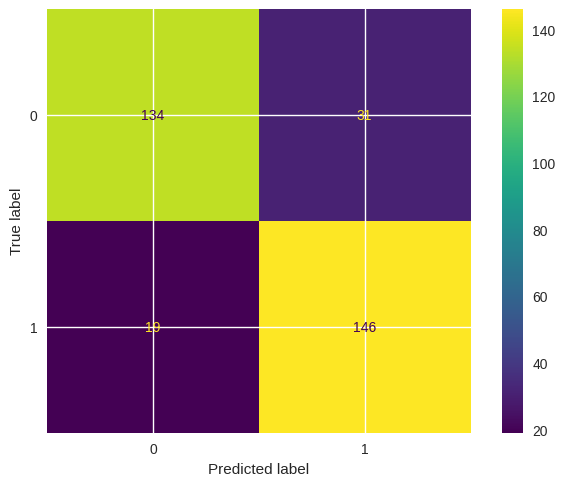

In [23]:
param_grid = {
    "Model__C": np.logspace(-3,3,7),
    "Model__penalty":["l1","l2"]
}

model, data, target = prepare_model(models["Logistic Regression"], ds)

grid_lr = GridSearchCV(model, param_grid, scoring="recall")

grid_lr.fit(data, target)

y_pred = grid_lr.best_estimator_.predict(data)
ConfusionMatrixDisplay(confusion_matrix(target, y_pred)).plot()

Tunando parâmetros foi possível diminuir um pouco o número de Falsos Negativos em ambos os modelos ... No entanto na SVM foi possível diminuir para zero! Portanto este é o modelo que nos dá o melhor resultado para a aplicação que queremos. Acabamos ficando com um grande número de Falsos Positivos, no entanto removemos os falsos negativos!

# Salvando o melhor modelo.

Já que escolhemos a SVM, vamos treiná-la usando todos os dados disponíveis e vamos guardar os resultados num pickle para recuperar o resultado no futuro.

In [27]:
import pickle
from os.path import isfile

out_file = "../outputs/best_model.pkl"

if not isfile(out_file):

    with open(out_file, "wb") as pkl:
        pickle.dump(grid_svc.best_estimator_ , pkl)

In [28]:
with open(out_file, 'rb') as pkl:
    model = pickle.load(pkl)

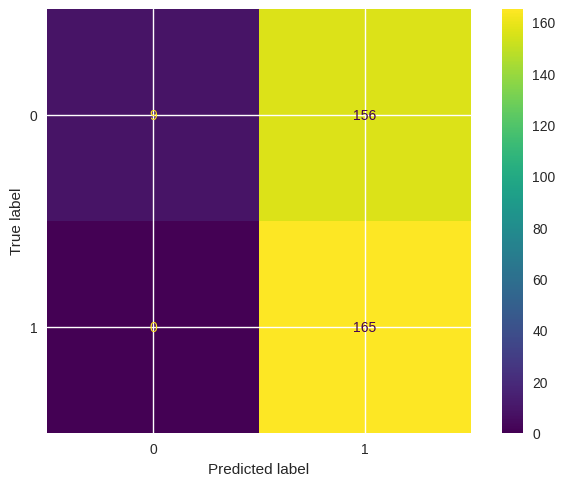

In [29]:
y_pred = model.predict(data)
ConfusionMatrixDisplay(confusion_matrix(target, y_pred)).plot()

Perfeito! Recuperamos a mesma matriz de confusão!